<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

fatal: destination path 'LIDC_GDRO' already exists and is not an empty directory.
/content/LIDC_GDRO


In [3]:
# !git pull

import necessary libraries

In [4]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages, train_epochs, show_scatter

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [7]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,1
1400,2,7,3,1,0,1
1435,3,6,3,1,1,1
1066,4,4,2,1,0,1
1244,5,4,2,1,2,1


First we load in the training data

In [8]:
train_data, cv_data, test_data = getImages(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [9]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [10]:
epochs = 15
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn='ERM', num_subgroups=4, scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.


In [11]:
test(tst_loader,model, 4)

(0.867109634551495,
 0.96875,
 0.9090909090909091,
 0.6567164179104478,
 0.9210526315789473)

### Feature Extraction

We first save model weights (for reproducibility)

In [12]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [13]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [14]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [15]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [16]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,256,0.416874,0.037589,0.000000,0.360054,0.699317,0.000000,0.609821,3.409549,0.000000,...,0.152551,0.640647,2.704610,0.214025,3.985926,0.128656,0.075015,0,0,0
1,2341,0.951851,0.000000,1.018645,1.719266,0.445743,0.923703,1.372358,2.296300,0.047846,...,0.212402,1.122590,2.743288,1.448920,3.119571,0.000000,0.000000,0,0,0
2,2114,0.262059,0.000000,4.632357,3.792300,0.650732,1.216533,4.116080,2.643375,0.000000,...,0.073455,2.243150,1.630112,2.579019,0.413144,1.541162,0.000000,0,0,0
3,1667,0.523033,0.126448,0.147222,0.990565,0.721274,0.000000,1.290121,0.510765,0.000000,...,0.204082,0.012931,2.813501,0.727531,0.554792,0.000000,0.009065,0,0,0
4,2274,2.750031,0.003833,0.000000,1.239265,0.294554,0.000000,0.000000,1.344473,0.000000,...,0.000000,0.159534,5.298711,0.079111,2.155135,0.105098,0.020233,0,0,0


We again save the data for reproducibility

In [17]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [18]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [19]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [20]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [21]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

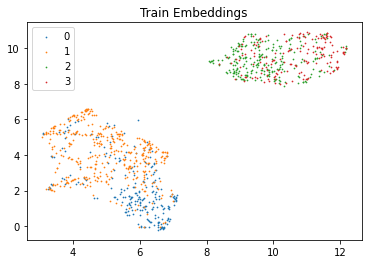

In [22]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [23]:
cv_test_embeds = reducer.transform(cv_test_features)

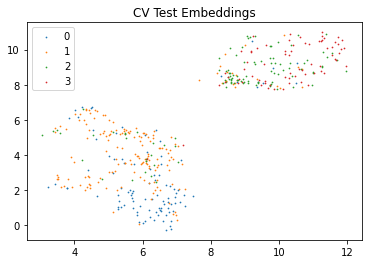

In [24]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [25]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [26]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

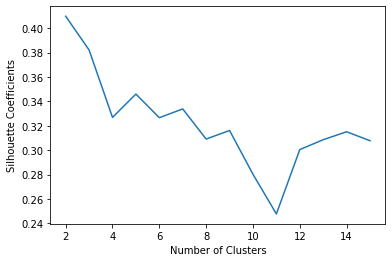

In [27]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [28]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

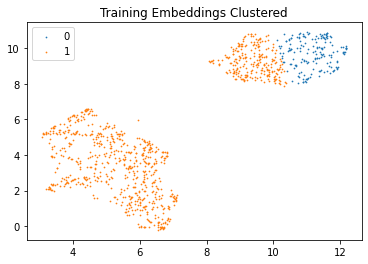

In [29]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

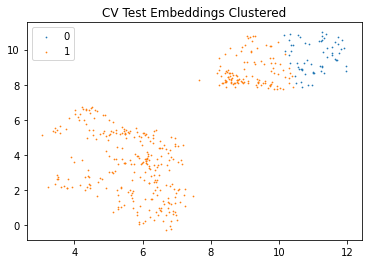

In [30]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [31]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [32]:
df_features_train['clusters'] = train_labels
df_features_cv_test['clusters'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'clusters']]
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,clusters
0,256,1
1,2341,1
2,2114,1
3,1667,1
4,2274,1


In [33]:
df_clusters = df_clusters.sort_values('noduleID')

We can add these lables to the df_splits dataframe

In [34]:
df_splits['clusters'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['clusters'])]

In [35]:
df_splits['clusters']

1295    1
1400    2
1435    1
1066    2
1244    2
       ..
1028    2
819     0
707     0
1436    1
501     0
Name: clusters, Length: 1488, dtype: int64

Now we save the csv

In [36]:
df_splits.to_csv('./data/LIDC_data_split.csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [37]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,1
1400,2,7,3,1,0,2
1435,3,6,3,1,1,1
1066,4,4,2,1,0,2
1244,5,4,2,1,2,2


In [38]:
train_data_c, cv_data_c, test_data_c = getImages(split=True, sublabels='clusters', binary=True, device=DEVICE)

#datasets
tr_c = SubclassedNoduleDataset(*train_data_c)
cv_c = SubclassedNoduleDataset(*cv_data_c)
tst_c = SubclassedNoduleDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=512)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

### ERM

In [39]:
model_ERM = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn='ERM', num_subgroups=3, scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15


In [42]:
test(tst_loader_c,model_ERM, 3)

(0.8837209302325582, 0.9065934065934066, 1.0, 0.7906976744186046)

### GDRO

In [46]:
model_gDRO = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_gDRO, loss_fn='gDRO', num_subgroups=3, scheduler=True, verbose=True)

Epoch 1/15
Average training loss: 0.7700639456510544
Accuracy: 0.7142857142857143 
Accuracy over subgroups: [0.97802198 0.31818182 0.26470588] 
Worst Group Accuracy: 0.2647058823529412
Epoch 2/15
Average training loss: 0.4172425627708435
Accuracy: 0.891156462585034 
Accuracy over subgroups: [0.97777778 1.         0.61111111] 
Worst Group Accuracy: 0.6111111111111112
Epoch 3/15
Average training loss: 0.25050086677074435
Accuracy: 0.8435374149659864 
Accuracy over subgroups: [0.87640449 1.         0.69230769] 
Worst Group Accuracy: 0.6923076923076923
Epoch 4/15
Average training loss: 0.1541615031659603
Accuracy: 0.7959183673469388 
Accuracy over subgroups: [0.80681818 0.80952381 0.76315789] 
Worst Group Accuracy: 0.7631578947368421
Epoch 5/15
Average training loss: 0.10145657509565353
Accuracy: 0.8299319727891157 
Accuracy over subgroups: [0.81818182 1.         0.81081081] 
Worst Group Accuracy: 0.8108108108108109
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
A

In [45]:
test(tst_loader_c,model_ERM, 3)

(0.8770764119601329, 0.8736842105263158, 1.0, 0.803030303030303)

### 20 Trials

In [50]:
def run_trials(runs, epochs, loss_fn):

  accuracies = []
  for run in range(runs):
    print(f'run {run+1}/{runs}')
    model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

    train_epochs(epochs, tr_loader_c, cv_loader_c, model_gDRO, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=True)

    accuracies.append(test(tst_loader_c,model, 3))

  return accuracies

### ERM

In [ ]:
accuracies = run_trials(20, 15, 'ERM')

run 1/20


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Average training loss: 0.09165849458659067
Accuracy: 0.8095238095238095 
Accuracy over subgroups: [0.86813187 0.875      0.65      ] 
Worst Group Accuracy: 0.65
Epoch 2/15
Average training loss: 0.08313883058726787
Accuracy: 0.8163265306122449 
Accuracy over subgroups: [0.77272727 1.         0.82051282] 
Worst Group Accuracy: 0.7727272727272727
Epoch 3/15
Average training loss: 0.059275056794285776
Accuracy: 0.8571428571428571 
Accuracy over subgroups: [0.88172043 1.         0.74358974] 
Worst Group Accuracy: 0.7435897435897436
Epoch 4/15
Average training loss: 0.059997600689530375
Accuracy: 0.8095238095238095 
Accuracy over subgroups: [0.83157895 1.         0.63636364] 
Worst Group Accuracy: 0.6363636363636364
Epoch 5/15
Average training loss: 0.03787297122180462
Accuracy: 0.891156462585034 
Accuracy over subgroups: [0.95918367 0.76470588 0.75      ] 
Worst Group Accuracy: 0.75
Epoch 6/15
Average training loss: 0.04412029050290585
Accuracy: 0.8435374149659864 
Accuracy over

### gDRO

In [ ]:
accuracies = run_trials(20, 15, 'gDRO')